# Project 1 Vector Quantization by LBG
LBG algorithm is like a K-means clustering algorithm which takes a set of input vectors $S = \{xi ∈ Rd| i = 1, 2, \dots, n\}$ as input and generates a representative subset of vectors $C = \{cj ∈ Rd| j = 1, 2, \dots, K\}$ with a user specified $K \ll n$ as output according to the similarity measure. For the application of Vector Quantization (VQ), $d = 16$, $K = 256$ or $512$ are commonly used.

## Plot the Images for Training our Codebook.

origin shape: [(262144,), (262144,), (262144,), (262144,)]
['lenna.raw', 'mandrill.raw', 'scene.raw', 'tiffany.raw']
[(512, 512, 1), (512, 512, 1), (512, 512, 1), (512, 512, 1)]


<Figure size 432x288 with 0 Axes>

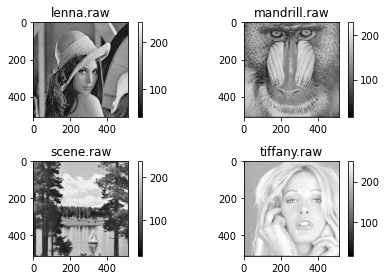

In [1]:
import numpy as np
import matplotlib.pyplot as plt
img_name = ["lenna.raw", "mandrill.raw", "scene.raw","tiffany.raw"]
S = []
for itsName in img_name:
    S.append(np.fromfile(itsName, dtype="uint8"))
print("origin shape:",[i.shape for i in S])

img = [i.reshape(512, 512, 1) for i in S]
print([img_name[i] for i in range(len(img))])
print([img[i].shape for i in range(len(img))])

plt.figure()
fig, ax = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        im = ax[i, j].imshow(img[2*i+j], cmap="gray")
        fig.colorbar(im, ax=ax[i, j])
        ax[i, j].set_title(img_name[2*i+j])
fig.tight_layout()
plt.show()

## LBG Algorithm
1. Input training vector $S=\{x_i \in R^d| i=1,2,\dots,n\}$
2. Initiate a codebook $C=\{c_j\in R^d| j=1,2,\dots,K\}$
3. Set $D_0=0$ and let $k=0$.
4. Classify the $n$ training vectors into $K$ clusters according to $x_i\in S_q$ if $||x_i - c_q||_p \leq ||x_i - c_j||_p $ for $j \neq q$. 
5. Update cluster centers $c_j$, $j = 1, 2, \dots, K$ by $c_j = \frac{1}{|S_j|}\sum_{x_i\in S_j} x_i$
6. Set $k \leftarrow k+1$ and compute the distortion $D_k=\sum_{j=1}^K\sum_{x_i \in S_j} ||x_i - c_j||_p$
7. If $(D_{k-1}-D_k)/D_k > \epsilon$, repeat step 4~6
8. Output the codebook $C= \{ c_j \in R^d| j = 1,2,\dots ,K \}$

### Step 1: Input training vector $S=\{x_i \in R^d| i=1,2,\dots,n\}$

In [2]:
'''
1. Input training vector S
'''
S_trainingSet = []
for img_index in range(4): # ["lenna.raw", "mandrill.raw", "scene.raw","tiffany.raw"]
    for i in range(0, 512, 4): # up to down
        for j in range(0, 512, 4): # left to right
            S_trainingSet.append(img[img_index][i:4+i, j:4+j, 0])

S_trainingSet_tmp = [i.flatten() for i in S_trainingSet]
S_trainingSet = S_trainingSet_tmp
del S_trainingSet_tmp
n = len(S_trainingSet) # S's size
print("n =", n)
S = np.array(S_trainingSet)
print(S.shape) # S's size and each element's size
S = S.astype('float32')
print(S)

n = 65536
(65536, 16)
[[166. 166. 166. ... 166. 166. 164.]
 [166. 160. 166. ... 160. 166. 164.]
 [168. 164. 165. ... 164. 165. 163.]
 ...
 [224. 224. 221. ... 200. 200. 200.]
 [217. 217. 221. ... 200. 200. 200.]
 [224. 225. 226. ... 200. 200. 200.]]


### Step 2: Initiate a codebook $C=\{c_j\in R^d| j=1,2,\dots,K\}$
Init by randomly selecting from $S$

K = 512
(512, 16)
[[150. 148. 148. ... 151. 147. 146.]
 [177. 184. 180. ... 180. 180. 178.]
 [208. 209. 207. ... 206. 208. 209.]
 ...
 [ 85.  91.  85. ...  89.  89.  92.]
 [217. 219. 217. ... 217. 215. 215.]
 [ 75.  63.  67. ...  93.  95. 114.]]


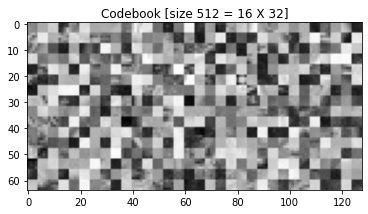

In [3]:
'''
2. Initiate a codebook C
'''
from numpy.random import default_rng
from tqdm import tqdm, trange
K = 512
C_codebook = []
rng = default_rng()
# random_index = rng.choice(n-1, size=K, replace=False)
# with open('random_index.npy', 'wb') as f:
#     np.save(f, random_index)
with open('random_index.npy', 'rb') as f:
    random_index = np.load(f)
for i in random_index:
    C_codebook.append(S_trainingSet[i])
print("K =", len(C_codebook))
C = np.array(C_codebook)
C = C.astype('float32')
print(C.shape) # C's size and each element's size
print(C)

def showCodebook(codebookInput):
    Copy_c = np.copy(codebookInput)
    Copy_c = Copy_c.reshape(512, 4, 4)
    Copy_c = Copy_c.reshape(16, 32, 4, 4)

    Copy_c = np.concatenate(Copy_c, axis=1)
    Copy_c = np.concatenate(Copy_c, axis=1)
    plt.figure()
    plt.title("Codebook [size 512 = 16 X 32]")
    plt.imshow(Copy_c, cmap="gray")

showCodebook(C)

### Step 3: Set $D_0=0$ and let $k=0$.
Set D as a list, and D[0]=0

In [4]:
'''
3. Set D = [0] and let k = 0
'''
D = [0]
k = 0

### Stpe 4: Classify the $n$ training vectors into $K$ clusters according to $x_i\in S_q$ if $||x_i - c_q||_p \leq ||x_i - c_j||_p $ for $j \neq q$. 

In [5]:
'''
4. Classify the n training vectors into K clusters
'''
from tqdm import tqdm, trange

def step4_clustering():
    # init the clusterUpdate_table
    clusterUpdate_table = []
    for i in range(K):
        clusterUpdate_table.append([])

    # Update the clusterUpdate_table
    for ind in tqdm(range(n)):
        i = S[ind,:]
        cmp = C-i
        cmp_ = np.linalg.norm(cmp, axis=1)
        clusterUpdate_table[np.argmin(cmp_)].append(ind)
    print("Update Cluster Update Table Successfully!")
    return clusterUpdate_table

clusterUpdate_table = step4_clustering()

100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 37833.30it/s]


Update Cluster Update Table Successfully!


### Step 5: Update cluster centers $c_j$, $j = 1, 2, \dots, K$ by $c_j = \frac{1}{|S_j|}\sum_{x_i\in S_j} x_i$

In [6]:
'''
5. Update cluster center c
'''

def step5_UpdateCenters(C, K, clusterUpdate_table):
    for i in range(K):
        tmp = np.zeros((16))
        for code_ind in clusterUpdate_table[i]:
            tmp = tmp + S[code_ind, :]
        tmp = tmp/len(clusterUpdate_table[i])
        C[i, :] = tmp

# for i in range(K):
#     tmp = np.zeros((16))
#     for code_ind in clusterUpdate_table[i]:
#         tmp = tmp + S[code_ind, :]
#     tmp = tmp/len(clusterUpdate_table[i])
#     C[i, :] = tmp
step5_UpdateCenters(C, K, clusterUpdate_table)
print("Update Cluster Center c Successfully!")

Update Cluster Center c Successfully!


### Step 6: Set $k \leftarrow k+1$ and compute the distortion $D_k=\sum_{j=1}^K\sum_{x_i \in S_j} ||x_i - c_j||_p$

In [7]:
'''
6. Set k <- k+1 and compute the distortion D
'''
def step6_UpdatekandD(k, D):
    k = k+1
    D_new = 0
    for j in range(K):
        for code_ind in clusterUpdate_table[j]:
            D_new = D_new + np.linalg.norm(S[code_ind, :]-C[j,:])

    D.append(D_new)
    print("D_{}={}".format(k, D_new))
    return k, D
k, D = step6_UpdatekandD(k, D)
print(len(D))

D_1=2122844.2416660786
2


### Step 7: If $(D_{k-1}-D_k)/D_k > \epsilon$, repeat step 4~6

In [8]:
'''
7. If (D_{k-1} - D_k)/D_k > a small number, repeat steps 4~6
'''
from tqdm import tqdm, trange
num_run = 1
while (num_run < 100 and (abs(D[-1]-D[-2])/D[-1])>0.000001):
    num_run=num_run+1

    clusterUpdate_table = step4_clustering() # Step 4: Classify the n training vectors into K clusters
    step5_UpdateCenters(C, K, clusterUpdate_table) # Step 5: Update cluster center c
    k, D = step6_UpdatekandD(k, D) # Step 6: Set k <- k+1 and compute the distortion D 

100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38785.78it/s]


Update Cluster Update Table Successfully!


  5%|███▉                                                                      | 3523/65536 [00:00<00:01, 35160.20it/s]

D_2=2028215.0192307234


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38889.42it/s]


Update Cluster Update Table Successfully!


  6%|████▍                                                                     | 3885/65536 [00:00<00:01, 34574.01it/s]

D_3=1996080.235835433


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38999.78it/s]


Update Cluster Update Table Successfully!


 12%|████████▊                                                                 | 7857/65536 [00:00<00:01, 38692.55it/s]

D_4=1978516.8639023304


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 39607.78it/s]


Update Cluster Update Table Successfully!


  6%|████▎                                                                     | 3843/65536 [00:00<00:01, 35751.59it/s]

D_5=1967314.9713542461


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38883.28it/s]


Update Cluster Update Table Successfully!


 11%|████████▏                                                                 | 7303/65536 [00:00<00:01, 34926.67it/s]

D_6=1959711.8116719723


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 39444.35it/s]


Update Cluster Update Table Successfully!


 12%|████████▊                                                                 | 7836/65536 [00:00<00:01, 37236.58it/s]

D_7=1954787.5514662266


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 39306.15it/s]


Update Cluster Update Table Successfully!


  6%|████▏                                                                     | 3729/65536 [00:00<00:01, 36936.64it/s]

D_8=1951035.6178578138


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38805.41it/s]


Update Cluster Update Table Successfully!


  6%|████▏                                                                     | 3682/65536 [00:00<00:01, 35128.96it/s]

D_9=1948347.5747947693


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 36173.68it/s]


Update Cluster Update Table Successfully!


  6%|████▏                                                                     | 3672/65536 [00:00<00:01, 34707.18it/s]

D_10=1946147.0545660257


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 37257.74it/s]


Update Cluster Update Table Successfully!


  6%|████                                                                      | 3641/65536 [00:00<00:01, 35033.04it/s]

D_11=1944339.5390722752


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38910.14it/s]


Update Cluster Update Table Successfully!


  6%|████▎                                                                     | 3780/65536 [00:00<00:01, 36886.73it/s]

D_12=1942895.755792141


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 35708.26it/s]


Update Cluster Update Table Successfully!


 12%|████████▊                                                                 | 7821/65536 [00:00<00:01, 37704.39it/s]

D_13=1941729.487687111


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38908.51it/s]


Update Cluster Update Table Successfully!


  5%|███▊                                                                      | 3397/65536 [00:00<00:01, 33793.10it/s]

D_14=1940902.5367776155


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 35319.17it/s]


Update Cluster Update Table Successfully!


  6%|████▋                                                                     | 4185/65536 [00:00<00:01, 39080.24it/s]

D_15=1940103.790676117


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38584.93it/s]


Update Cluster Update Table Successfully!


  6%|████▎                                                                     | 3782/65536 [00:00<00:01, 36560.22it/s]

D_16=1939349.5459313393


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38401.00it/s]


Update Cluster Update Table Successfully!


  6%|████▏                                                                     | 3698/65536 [00:00<00:01, 36412.70it/s]

D_17=1938713.6928761005


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 37834.18it/s]


Update Cluster Update Table Successfully!


 11%|████████▎                                                                 | 7311/65536 [00:00<00:01, 34475.24it/s]

D_18=1938120.5664122105


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 37789.77it/s]


Update Cluster Update Table Successfully!


 12%|████████▋                                                                 | 7740/65536 [00:00<00:01, 36595.22it/s]

D_19=1937532.33129704


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38172.72it/s]


Update Cluster Update Table Successfully!


  6%|████▊                                                                     | 4209/65536 [00:00<00:01, 39080.83it/s]

D_20=1937126.3431706429


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 39367.00it/s]


Update Cluster Update Table Successfully!


  6%|████▌                                                                     | 4087/65536 [00:00<00:01, 38492.38it/s]

D_21=1936720.9329789877


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 39574.33it/s]


Update Cluster Update Table Successfully!


  6%|████▌                                                                     | 4030/65536 [00:00<00:01, 38010.77it/s]

D_22=1936300.792206645


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 39605.70it/s]


Update Cluster Update Table Successfully!


  6%|████▎                                                                     | 3848/65536 [00:00<00:01, 36250.62it/s]

D_23=1935882.7642503977


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 39413.62it/s]


Update Cluster Update Table Successfully!


  6%|████▌                                                                     | 4063/65536 [00:00<00:01, 37860.40it/s]

D_24=1935285.5505568981


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 39398.16it/s]


Update Cluster Update Table Successfully!


  6%|████▌                                                                     | 4023/65536 [00:00<00:01, 38237.79it/s]

D_25=1934683.8370494843


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 39848.48it/s]


Update Cluster Update Table Successfully!


 12%|████████▉                                                                 | 7934/65536 [00:00<00:01, 38516.03it/s]

D_26=1934304.5241099596


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 39515.77it/s]


Update Cluster Update Table Successfully!


  6%|████▍                                                                     | 3955/65536 [00:00<00:01, 37006.45it/s]

D_27=1934124.9501322508


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 37679.06it/s]


Update Cluster Update Table Successfully!


  6%|████▌                                                                     | 4059/65536 [00:00<00:01, 38899.33it/s]

D_28=1933771.3985103369


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38141.80it/s]


Update Cluster Update Table Successfully!


  6%|████▍                                                                     | 3957/65536 [00:00<00:01, 38076.15it/s]

D_29=1933287.625034213


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38414.83it/s]


Update Cluster Update Table Successfully!


 12%|█████████                                                                 | 7981/65536 [00:00<00:01, 37594.22it/s]

D_30=1932854.547277689


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38412.31it/s]


Update Cluster Update Table Successfully!


  7%|████▊                                                                     | 4307/65536 [00:00<00:01, 39028.71it/s]

D_31=1932524.6546337605


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38627.15it/s]


Update Cluster Update Table Successfully!


  6%|████▍                                                                     | 3880/65536 [00:00<00:01, 37576.69it/s]

D_32=1932294.2651877403


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38087.18it/s]


Update Cluster Update Table Successfully!


 11%|████████▍                                                                 | 7454/65536 [00:00<00:01, 35997.09it/s]

D_33=1932038.2963142395


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38082.28it/s]


Update Cluster Update Table Successfully!


  6%|████▍                                                                     | 3883/65536 [00:00<00:01, 38281.77it/s]

D_34=1931570.8948335648


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38815.67it/s]


Update Cluster Update Table Successfully!


  6%|████▋                                                                     | 4127/65536 [00:00<00:01, 38695.25it/s]

D_35=1930878.6578278542


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38526.33it/s]


Update Cluster Update Table Successfully!


  6%|████▍                                                                     | 3925/65536 [00:00<00:01, 37142.19it/s]

D_36=1930601.3071746826


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 36419.51it/s]


Update Cluster Update Table Successfully!


  5%|████                                                                      | 3603/65536 [00:00<00:01, 34076.58it/s]

D_37=1930367.2304618359


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 33388.49it/s]


Update Cluster Update Table Successfully!


  6%|████▏                                                                     | 3692/65536 [00:00<00:01, 36259.48it/s]

D_38=1930237.2402199507


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 37784.41it/s]


Update Cluster Update Table Successfully!


  6%|████▎                                                                     | 3814/65536 [00:00<00:01, 36355.17it/s]

D_39=1930143.1048213243


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38072.61it/s]


Update Cluster Update Table Successfully!


 12%|████████▉                                                                 | 7951/65536 [00:00<00:01, 37522.07it/s]

D_40=1930004.3483520746


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38825.00it/s]


Update Cluster Update Table Successfully!


  5%|███▉                                                                      | 3459/65536 [00:00<00:01, 32110.14it/s]

D_41=1929916.6236342192


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38049.76it/s]


Update Cluster Update Table Successfully!


 12%|████████▊                                                                 | 7845/65536 [00:00<00:01, 38074.43it/s]

D_42=1929839.0680414438


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38354.31it/s]


Update Cluster Update Table Successfully!


 12%|█████████                                                                 | 8068/65536 [00:00<00:01, 38352.92it/s]

D_43=1929771.7488452196


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38406.02it/s]


Update Cluster Update Table Successfully!


  6%|████▌                                                                     | 4095/65536 [00:00<00:01, 38509.88it/s]

D_44=1929714.5597554445


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38363.82it/s]


Update Cluster Update Table Successfully!


  6%|████▎                                                                     | 3787/65536 [00:00<00:01, 35309.56it/s]

D_45=1929648.7576173544


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38231.77it/s]


Update Cluster Update Table Successfully!


 12%|████████▊                                                                 | 7754/65536 [00:00<00:01, 37203.26it/s]

D_46=1929626.0439552069


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38382.92it/s]


Update Cluster Update Table Successfully!


  6%|████▍                                                                     | 3912/65536 [00:00<00:01, 36389.86it/s]

D_47=1929609.630916357


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38299.15it/s]


Update Cluster Update Table Successfully!


 12%|████████▊                                                                 | 7754/65536 [00:00<00:01, 37490.35it/s]

D_48=1929556.604823351


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 37530.76it/s]


Update Cluster Update Table Successfully!


  6%|████▏                                                                     | 3669/65536 [00:00<00:01, 35283.34it/s]

D_49=1929522.2581324577


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 36015.23it/s]


Update Cluster Update Table Successfully!


  6%|████▋                                                                     | 4099/65536 [00:00<00:01, 38213.60it/s]

D_50=1929482.0841929913


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 38281.78it/s]


Update Cluster Update Table Successfully!


  6%|████▏                                                                     | 3717/65536 [00:00<00:01, 35549.65it/s]

D_51=1929430.990629673


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 36909.77it/s]


Update Cluster Update Table Successfully!


 11%|████████▍                                                                 | 7485/65536 [00:00<00:01, 34816.86it/s]

D_52=1929413.655878067


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 36874.33it/s]


Update Cluster Update Table Successfully!


  6%|████▌                                                                     | 3993/65536 [00:00<00:01, 38155.75it/s]

D_53=1929417.5201671124


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 36985.36it/s]


Update Cluster Update Table Successfully!


  6%|████▎                                                                     | 3869/65536 [00:00<00:01, 36340.55it/s]

D_54=1929415.475533247


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 36290.69it/s]


Update Cluster Update Table Successfully!


 12%|████████▌                                                                 | 7601/65536 [00:00<00:01, 37592.59it/s]

D_55=1929431.6965389252


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 36853.69it/s]


Update Cluster Update Table Successfully!


 12%|████████▉                                                                 | 7905/65536 [00:00<00:01, 37000.84it/s]

D_56=1929411.2504401207


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 37429.38it/s]


Update Cluster Update Table Successfully!


  5%|███▉                                                                      | 3527/65536 [00:00<00:01, 34787.57it/s]

D_57=1929377.7167212963


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 36091.98it/s]


Update Cluster Update Table Successfully!


  6%|████▏                                                                     | 3731/65536 [00:00<00:01, 35549.87it/s]

D_58=1929367.5053679943


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 36906.61it/s]


Update Cluster Update Table Successfully!


  6%|████▏                                                                     | 3659/65536 [00:00<00:01, 36079.42it/s]

D_59=1929359.894575119


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 37208.17it/s]


Update Cluster Update Table Successfully!


  6%|████▏                                                                     | 3685/65536 [00:00<00:01, 36198.02it/s]

D_60=1929347.3354349136


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 37514.27it/s]


Update Cluster Update Table Successfully!


  6%|████▏                                                                     | 3701/65536 [00:00<00:01, 34637.53it/s]

D_61=1929338.4330000877


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 37589.02it/s]


Update Cluster Update Table Successfully!


 12%|████████▊                                                                 | 7819/65536 [00:00<00:01, 38101.63it/s]

D_62=1929330.9304730892


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 37315.52it/s]


Update Cluster Update Table Successfully!


  6%|████▍                                                                     | 3938/65536 [00:00<00:01, 36759.71it/s]

D_63=1929334.9759407043


100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 36963.85it/s]


Update Cluster Update Table Successfully!
D_64=1929333.1658437252


### Plot D - # iterations to check it has converged

9.381982392603788e-07 < 0.000001
-6.180176073962114e-08


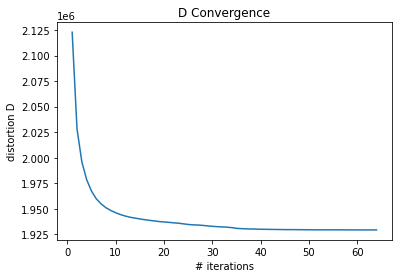

In [27]:
plt.figure()
plt.title("D Convergence")
plt.plot(range(1, len(D)),D[1:])
plt.xlabel('# iterations')
plt.ylabel('distortion D')
print(abs((D[-2]-D[-1])/D[-1]), "< 0.000001")
print(((D[-2]-D[-1])/D[-1]) - 0.000001)

### Show our Codebook after LBG algorithm

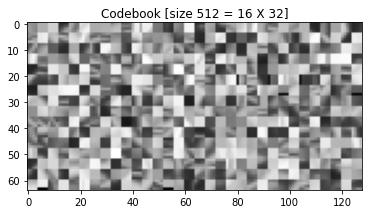

In [10]:
# visulize codebook
Copy_c = C
Copy_c = Copy_c.reshape(512, 4, 4)
Copy_c = Copy_c.reshape(16, 32, 4, 4)

Copy_c = np.concatenate(Copy_c, axis=1)
Copy_c = np.concatenate(Copy_c, axis=1)
plt.figure()
plt.title("Codebook [size 512 = 16 X 32]")
plt.imshow(Copy_c, cmap="gray")

## Perform Image Compression by VQ and Report Decoded Images 
### Perform Image Compression by VQ

In [11]:
def VQ(Sin, Cin):
    clusterTable = []
    for i in range(K):
        clusterTable.append([])
    for ind in trange(S.shape[0]):
        vec = Sin[ind,:]
        cmp = Cin-vec
        cmp_ = np.linalg.norm(cmp, axis=1)
        clusterTable[np.argmin(cmp_)].append(ind)
    print("cluster update table done!")
    return clusterTable

clusterUpdate_table = VQ(S, C)

100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:01<00:00, 36333.62it/s]

cluster update table done!


### Decode the Images

100%|██████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 3202.20it/s]


<Figure size 432x288 with 0 Axes>

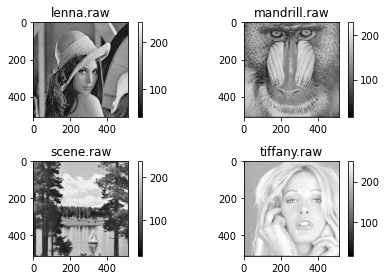

<Figure size 432x288 with 0 Axes>

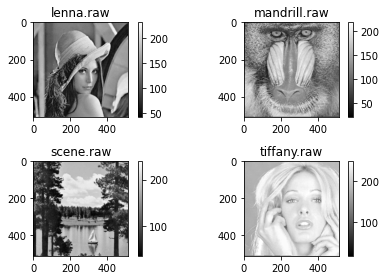

In [12]:
dict_img = {}

for names in img_name:
    dict_img[names] = np.zeros((512, 512, 1))
    
div_n = int(n/4)
for indList_num in trange(K):
    decode_img = np.array(C[indList_num, :]).reshape(4, 4, 1)
    for ind in clusterUpdate_table[indList_num]:
        if (ind>=0 and ind<div_n):
            ind_cnt = ind
            c = ind_cnt%128
            r = int((ind_cnt-(ind_cnt%128))/128)
            dict_img[img_name[0]][r*4:r*4+4, c*4:c*4+4,0] = decode_img[:,:,0]
        elif (ind >= div_n and ind < 2*div_n):
            ind_cnt = ind - div_n
            c = ind_cnt%128
            r = int((ind_cnt-(ind_cnt%128))/128)
            dict_img[img_name[1]][r*4:r*4+4, c*4:c*4+4,0] = decode_img[:,:,0]
        elif (ind >= 2*div_n and ind < 3*div_n):
            ind_cnt = ind - 2*div_n
            c = ind_cnt%128
            r = int((ind_cnt-(ind_cnt%128))/128)
            dict_img[img_name[2]][r*4:r*4+4, c*4:c*4+4,0] = decode_img[:,:,0]
        elif (ind >= 3*div_n and ind < 4*div_n):
            ind_cnt = ind - 3*div_n
            c = ind_cnt%128
            r = int((ind_cnt-(ind_cnt%128))/128)
            dict_img[img_name[3]][r*4:r*4+4, c*4:c*4+4,0] = decode_img[:,:,0]
        else:
            print("Error")
            
import matplotlib.pyplot as plt
plt.figure(0)
fig, ax = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        im = ax[i, j].imshow(img[2*i+j], cmap="gray")
        fig.colorbar(im, ax=ax[i, j])
        ax[i, j].set_title(img_name[2*i+j])
fig.tight_layout()
plt.show()

plt.figure(1)
fig, ax = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        im = ax[i, j].imshow(dict_img[img_name[2*i+j]], cmap="gray")
        fig.colorbar(im, ax=ax[i, j])
        ax[i, j].set_title(img_name[2*i+j])
fig.tight_layout()
plt.show()

## Compute PSNR
$$\text{PSNR}=10 \times \log (\frac{255^2}{\text{MSE}})$$
$$\text{MSE}=\frac{\sum_{n=1}^{\text{FrameSize}}(I_n-P_n)^2}{\text{FrameSize}}$$

In [13]:
def showPSNR(img1, img2, imgName):
    MSE = np.mean((img1-img2)**2)
    PSNR = 10* np.log10(255**2/MSE)
    print("PSNR of", imgName, PSNR)
for i in range(4):
    showPSNR(img[i], dict_img[img_name[i]], img_name[i])

PSNR of lenna.raw 32.099222560982284
PSNR of mandrill.raw 24.92227639483932
PSNR of scene.raw 29.154853872839563
PSNR of tiffany.raw 33.34586085252889


### jet and peppers ($512 \times 512$)

origin shape: [(262144,), (262144,)]
['jet.raw', 'peppers.raw']
[(512, 512, 1), (512, 512, 1)]


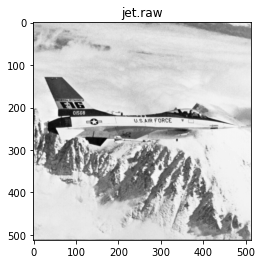

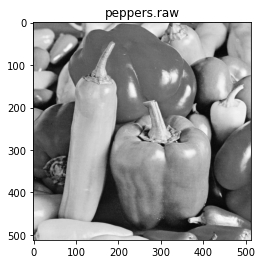

In [14]:
import numpy as np
import matplotlib.pyplot as plt
img2_name = ["jet.raw", "peppers.raw"]
img2_img = []
for itsName in img2_name:
    img2_img.append(np.fromfile(itsName, dtype="uint8"))
print("origin shape:",[i.shape for i in img2_img])

img2_img = [np.array(i.reshape(512, 512, 1)) for i in img2_img]
print([img2_name[i] for i in range(len(img2_name))])
print([img2_img[i].shape for i in range(len(img2_img))])
plt.close()
plt.figure(0)
plt.title(img2_name[0])
plt.imshow(img2_img[0], cmap="gray")
plt.show()
plt.figure(1)
plt.title(img2_name[1])
plt.imshow(img2_img[1], cmap="gray")
plt.show()

In [15]:
img2_img[0]
# dict_img2_compress[img2_name[0]]
S_img2 = []
for img_index in range(2): # ["jet.raw", "peppers.raw"]
    for i in range(0, 512, 4): # up to down
        for j in range(0, 512, 4): # left to right
            S_img2.append(img2_img[img_index][i:4+i, j:4+j, 0])

tmp = [i.flatten() for i in S_img2]
S_img2 = tmp
del tmp

S = np.array(S_img2)
S = S.astype('float32')
print(S)
print(S.shape)

[[ 76. 200. 194. ... 188. 189. 189.]
 [181. 186. 192. ... 182. 182. 184.]
 [192. 194. 201. ... 189. 185. 186.]
 ...
 [208. 201. 209. ... 197. 195. 195.]
 [193. 204. 202. ... 200. 195. 190.]
 [188. 203. 190. ... 185. 193. 197.]]
(32768, 16)


In [16]:
clusterTable = VQ(S, C)
print(len(clusterTable))

100%|█████████████████████████████████████████████████████████████████████████| 32768/32768 [00:00<00:00, 38048.95it/s]

cluster update table done!
512


In [17]:
def decoded_images(C, clusTable, img_name, num_encode, img_size):
    dict_img = {}
    for names in img_name:
        dict_img[names] = np.zeros((img_size, img_size, 1))
    
    div_n = int(num_encode/len(img_name))
    div_l = img_size/4
    # print(div_n)
    for indList_num in trange(len(clusTable)):
        decode_img = np.array(C[indList_num, :]).reshape(4, 4, 1)
        for ind in clusTable[indList_num]:
            for img_num_ind in range(len(img_name)):
                if (ind>=img_num_ind*div_n and ind<(img_num_ind+1)*div_n):
                    ind_cnt = ind - img_num_ind*div_n
                    c = int(ind_cnt%div_l)
                    r = int((ind_cnt-(ind_cnt%div_l))/div_l)
                    dict_img[img_name[img_num_ind]][r*4:r*4+4, c*4:c*4+4,0] = decode_img[:,:,0]
    
    for i in range(len(img_name)):
        plt.figure(i)
        plt.title(img_name[i])
        plt.imshow(dict_img[img_name[i]], cmap="gray")
        plt.show()
    return dict_img

100%|██████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 5427.04it/s]


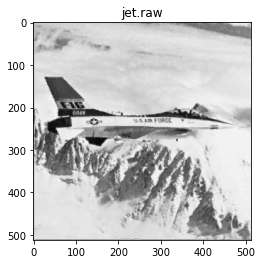

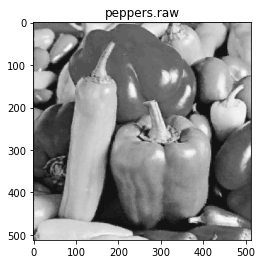

In [18]:
imgBack = decoded_images(C, clusterTable, img2_name, 32768, 512)

In [19]:
for i in range(2):
    MSE = np.mean((img2_img[i]-imgBack[img2_name[i]])**2)
    PSNR = 10* np.log10((255**2)/MSE)
    print("PSNR of", img2_name[i], PSNR)

PSNR of jet.raw 30.151580860091528
PSNR of peppers.raw 30.3483290134143


origin shape: [(16384,), (16384,)]
['891538.raw', '892539.raw']
[(128, 128, 1), (128, 128, 1)]


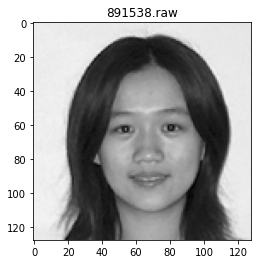

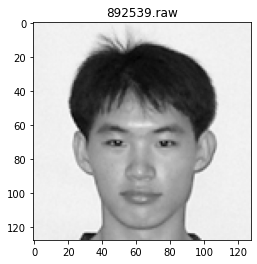

[[212. 214. 214. ... 215. 215. 215.]
 [211. 212. 214. ... 215. 215. 215.]
 [213. 214. 214. ... 215. 214. 215.]
 ...
 [231. 231. 231. ... 231. 230. 230.]
 [231. 231. 231. ... 231. 232. 231.]
 [230. 233. 231. ... 231. 230. 230.]]
(2048, 16)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
img3_name = ["891538.raw", "892539.raw"]
img3_img = []
for itsName in img3_name:
    img3_img.append(np.fromfile(itsName, dtype="uint8"))
print("origin shape:",[i.shape for i in img3_img])

img3_img = [np.array(i.reshape(128, 128, 1)) for i in img3_img]
print([img3_name[i] for i in range(len(img3_name))])
print([img3_img[i].shape for i in range(len(img3_img))])
plt.close()
plt.figure(0)
plt.title(img3_name[0])
plt.imshow(img3_img[0], cmap="gray")
plt.show()
plt.figure(1)
plt.title(img3_name[1])
plt.imshow(img3_img[1], cmap="gray")
plt.show()

img3_img[0]
# dict_img2_compress[img2_name[0]]
S_img3 = []
for img_index in range(2): # ["jet.raw", "peppers.raw"]
    for i in range(0, 128, 4): # up to down
        for j in range(0, 128, 4): # left to right
            S_img3.append(img3_img[img_index][i:4+i, j:4+j, 0])

tmp = [i.flatten() for i in S_img3]
S_img3 = tmp
del tmp

S = np.array(S_img3)
S = S.astype('float32')
print(S)
print(S.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 64452.22it/s]

cluster update table done!
512
[465, 558, 590, 625, 819, 1492, 1689, 1712, 1750, 1782]


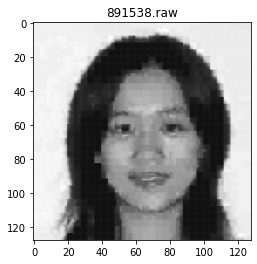

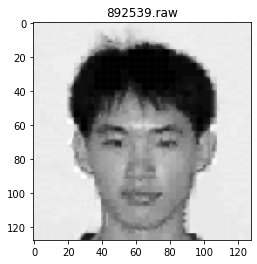

In [21]:
clusterTable = VQ(S, C)
print(len(clusterTable))
print(clusterTable[0])
imgBack = decoded_images(C, clusterTable, img3_name, 2048, 128)

## Compute PSNR
$$\text{PSNR}=10 \times \log (\frac{255^2}{\text{MSE}})$$
$$\text{MSE}=\frac{\sum_{n=1}^{\text{FrameSize}}(I_n-P_n)^2}{\text{FrameSize}}$$

In [22]:
for i in range(2):
    showPSNR(img3_img[i], imgBack[img3_name[i]], img3_name[i])

PSNR of 891538.raw 27.903657949822424
PSNR of 892539.raw 28.814077171027893


## Compute CPU Times
* Please change img_name and img_size to one of the images above

100%|████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 128361.25it/s]

origin shape: [(16384,)]
['892539.raw']
[(128, 128, 1)]
[[229. 231. 232. ... 232. 233. 231.]
 [231. 232. 231. ... 233. 232. 232.]
 [233. 231. 231. ... 234. 234. 235.]
 ...
 [231. 231. 231. ... 231. 230. 230.]
 [231. 231. 231. ... 231. 232. 231.]
 [230. 233. 231. ... 231. 230. 230.]]
(1024, 16)
cluster update table done!


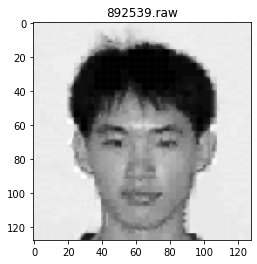

CPU TIME: 0.17460298538208008


In [26]:
import numpy as np
import matplotlib.pyplot as plt
img_name = ["892539.raw"]
img_size = 512
img_size = 128
img_img = []
for itsName in img_name:
    img_img.append(np.fromfile(itsName, dtype="uint8"))
print("origin shape:",[i.shape for i in img_img])

img_img = [np.array(i.reshape(img_size, img_size, 1)) for i in img_img]
print([img_name[i] for i in range(len(img_name))])
print([img_img[i].shape for i in range(len(img_img))])
# dict_img2_compress[img2_name[0]]
S_img3 = []
for img_index in range(1): 
    for i in range(0, img_size, 4): # up to down
        for j in range(0, img_size, 4): # left to right
            S_img3.append(img_img[img_index][i:4+i, j:4+j, 0])

tmp = [i.flatten() for i in S_img3]
S_img3 = tmp
del tmp

S = np.array(S_img3)
S = S.astype('float32')
print(S)
print(S.shape)
import time
seconds_start = time.time()
clusterTable = VQ(S, C)
imgBack = decoded_images(C, clusterTable, img_name, S.shape[0], img_size)
print("CPU TIME:",time.time()-seconds_start)